<a href="https://colab.research.google.com/github/abeashvil/MLWinePrediction/blob/main/first_ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df.dropna(subset=['description','points'])

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Pinot Gris,Domaine Marcel Deiss


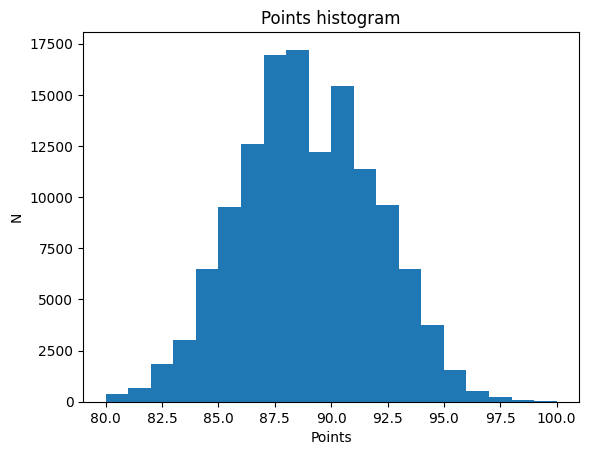

In [ ]:
plt.hist(df.points, bins = 20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [ ]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'points', 'label']]

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size = len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"This blend of 54% Grenache, 34% Syrah, 9% Mourv\xc3\xa8dre and 3% Cinsault boasts some brambly fruit, but that's dominated by notes of leather and clove. It shows decent weight and concentration on the palate, but just a bit rustic overall.",
        b'This blend of 43% Cabernet Sauvignon, 29% Merlot, 15% Malbec, 10% Cabernet Franc and 3% Petit Verdot is bitter and astringent.',
        b'This sports a smoky aroma, wrapped into tight, tart red fruits. There is an ashy undertone, and somewhat granular tannins.',
        ...,
        b'This is a hearty blend of Cabernets Sauvignon and Franc, Merlot and Marzemino that delivers thick, dark intensity and penetrating aromas of blackberry, red currant, clove, allspice and ginger. The wine has thick extraction and dense succulence to match.',
        b'Light, fruity, very crisp in character, this is an apple and citrus driven wine as much as red fruits. There is an attractive, exotic t

# Embedding + Model

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.33606818, -0.25993666, -0.0740485 , ..., -0.11291832,
        -0.04329748,  0.05463606],
       [ 0.39306065, -0.15364335, -0.07251466, ..., -0.08119787,
         0.00323324, -0.11133835],
       [ 0.31152296, -0.35568285, -0.2065913 , ...,  0.01166021,
        -0.0700662 ,  0.01940524],
       ...,
       [ 0.43710455, -0.05555728,  0.01706082, ..., -0.11619342,
        -0.24936327,  0.10082319],
       [ 0.44668198, -0.32985204,  0.11265104, ..., -0.10410933,
        -0.22490127,  0.2522395 ],
       [ 0.29189047, -0.14076714, -0.11289947, ...,  0.12123272,
        -0.08971204,  0.00623217]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

102/102 [==============================] - 2s 14ms/step - loss: 0.6822 - accuracy: 0.6107


[0.6821931004524231, 0.6107466816902161]

In [ ]:
model.evaluate(valid_data)

13/13 [==============================] - 2s 153ms/step - loss: 0.3742 - accuracy: 0.8315


[0.37419798970222473, 0.8314995765686035]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 126s 1s/step - loss: 0.6229 - accuracy: 0.6499 - val_loss: 0.4893 - val_accuracy: 0.7804
Epoch 2/5
102/102 [==============================] - 118s 1s/step - loss: 0.4654 - accuracy: 0.7827 - val_loss: 0.3944 - val_accuracy: 0.8213
Epoch 3/5
102/102 [==============================] - 120s 1s/step - loss: 0.3942 - accuracy: 0.8288 - val_loss: 0.3753 - val_accuracy: 0.8290
Epoch 4/5
102/102 [==============================] - 119s 1s/step - loss: 0.3607 - accuracy: 0.8488 - val_loss: 0.3724 - val_accuracy: 0.8297
Epoch 5/5
102/102 [==============================] - 120s 1s/step - loss: 0.3372 - accuracy: 0.8610 - val_loss: 0.3742 - val_accuracy: 0.8315


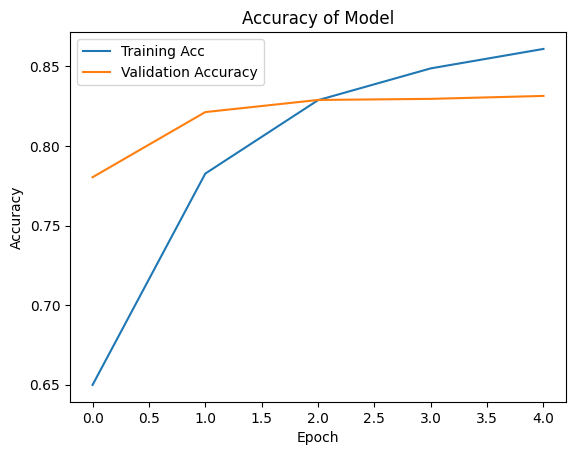

In [ ]:
plt.plot(history.history['accuracy'], label= "Training Acc")
plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
plt.title("Accuracy of Model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

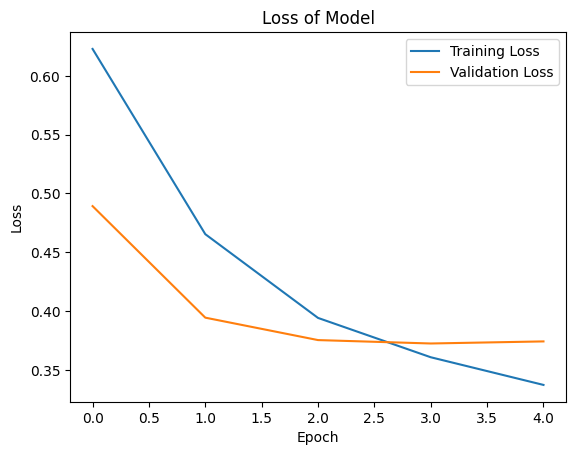

In [ ]:
plt.plot(history.history['loss'], label= "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.title("Loss of Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()